# Instrumental Noise in _Kepler_ and _K2_ #3: Seasonal and Detector Effects

## Learning Goals

By the end of this tutorial, you will:

- Be able to identify changes in data collection and processing caused by the _Kepler_ mission's seasonal cycles.
- Understand instrumental noise caused by physical features of the _Kepler_ telescope.
- Be able to compare the impact of different seasonal and detector-based noise sources.


## Introduction

This notebook is the third part of a series on identifying instrumental and systematic sources of noise in _Kepler_ and _K2_ data. The first two tutorials in this series are suggested (but not necessary) reading for working through this one. Assumed knowledge for this tutorial is a working familiarity with _Kepler_ light curve files, target pixel files, and their associated metadata, as well as a basic understanding of the transit method for detecting exoplants.

## Imports

We'll use **[Lightkurve](https://lightkurve.github.io/lightkurve/index.html)** for downloading and handling _Kepler_ data throughout this tutorial. We'll also use **[NumPy](https://numpy.org/)** to handle arrays for aperture masks, and **[Matplotlib](https://matplotlib.org/)** to help with some plotting.

In [1]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

/Users/nthom/lightkurve/src/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/nthom/.lightkurve/cache. Please move all the files in the legacy directory /Users/nthom/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


---

## 1. Background

The _Kepler_ telescope observed the same area of sky for four years, rotating every three months and dividing the mission into 18 observing quarters. This meant that the same star would fall on four different modules — and different pixels — throughout the mission.

In this tutorial, we'll explore three types of systematic effects caused by features of the detector, including those which are influenced by seasonal rotation. We will not cover any effects of the onboard electronics, nor the electronic response to external events, such as cosmic rays. These will be covered in the fourth and final tutorial in this series on instrumental noise.

## 2. Differential Velocity Aberration and Image Motion

In this section, we'll look at the changes in a star's position on two different scales: between quarters, and within one quarter.

Throughout the four-year nominal _Kepler_ mission, differential velocity aberration (DVA) was the main cause of changes in stellar positions ([_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf), Section 3.9). To understand DVA, first imagine the _Kepler_ telescope travelling through space. We can draw a "velocity vector" in the direction of the telescope's motion. We can draw similar vectors from every point on the focal plane, which represent lines of sight. The angle between the velocity vector and any given line of sight varies across the detector. Because the velocity vector changed each quarter during the _Kepler_ mission, the effective diameter of _Kepler's_ field of view changed by 6 arcseconds every year of the mission. This effect is on order 100 times greater than the effects of pointing instability; it leads to low frequency noise, which can be removed by light curve corrections. Because it's dependent on the line of sight, the effects of DVA are more pronounced towards the edges of the _Kepler_ field of view; some targets can move as much as half a pixel over the course of a quarter.

We can observe the effects of DVA by looking at how one star's position changes across four quarters. The following code plots Quarters 8–11 for KIC 2437394, with the right ascension and declination overlayed using the [World Coordinate System](https://docs.astropy.org/en/stable/wcs/index.html) (WCS), which is stored in the target pixel files (TPFs).

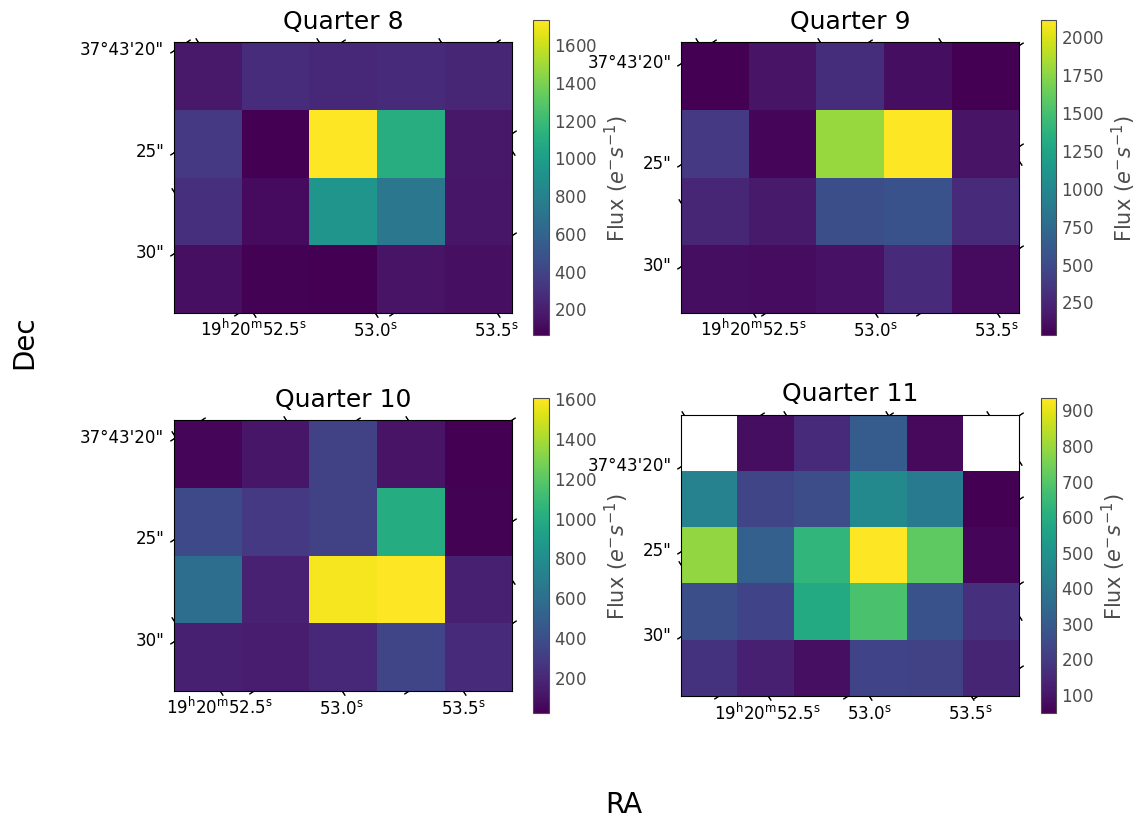

In [2]:
fig = plt.figure(figsize=(12, 9))
grid = gs.GridSpec(2,2)
plt.rcParams.update({'font.size': 12})

i = 0
for q in np.arange(8,12):
    x,y = np.unravel_index(i, (2,2))
    tpf = lk.search_targetpixelfile('KIC 2437394', author="Kepler", cadence="long", quarter=q).download()
    ax = plt.subplot(grid[x,y], projection=tpf.wcs)
    tpf.plot(ax=ax, title=f'Quarter {q}', xlabel=' ', ylabel=' ')
    i+=1

fig.text(0, 0.5, 'Dec', ha='center', rotation='vertical', size=20)
fig.text(0.5, 0, 'RA', ha='center', size=20);

In the above plots, you can see the changing pixel response function (PRF), (see [_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf), Section 3.5) as the star changes modules; we'll look at the result of this in Section 3 of this tutorial. Also notice the very slight changes in position, on the scale of seconds, between quarters. The star's coordinates themselves are not changing, but rather the angle between this part of the detector's line of sight and the telescope's velocity vector is changing.

DVA is one of the effects that contributed to image motion within quarters during the _Kepler_ mission ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.1). Additionally, target position was influenced by focus changes, as outlined in the second tutorial in this series, and other small pointing errors. These cumulative effects led to target motion on the detector by several 100ths of a pixel per quarter.

Image motion is measured onboard, and included in light curve and target pixel file metadata in the columns [pos_corr1](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.KeplerTargetPixelFile.pos_corr1.html) and [pos_corr2](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.KeplerTargetPixelFile.pos_corr2.html). We can use this data to visualize the image motion across one quarter:

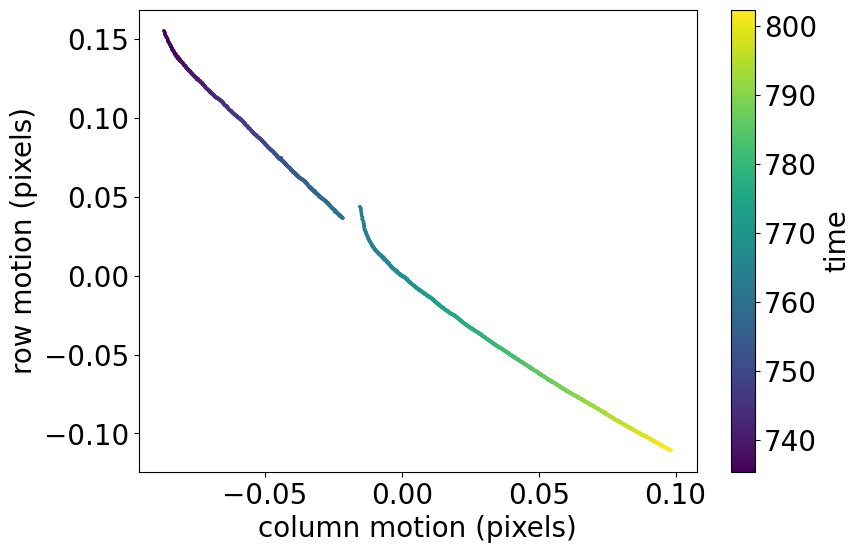

In [3]:
example_tpf = lk.search_targetpixelfile('KIC 2437394', author="Kepler", quarter=8).download()

fig = plt.figure()
plt.rcParams.update({'font.size': 20})

plt.scatter(example_tpf.pos_corr1, example_tpf.pos_corr2, c=example_tpf.time.value, s=2)
plt.xlabel('column motion (pixels)')
plt.ylabel('row motion (pixels)')
cbar = plt.colorbar()
cbar.set_label('time')

fig.set_size_inches(9,6)

## 3. Quarter Boundary Discontinuities

When a star was observed by new pixels in a new quarter, it was also subject to a different pixel response function (PRF). Because of this, the data processing pipeline also changed its optimal aperture, used to select pixels for aperture photometry. 

For most stars, these changes were not drastic. Additionally, incorrect optimal apertures in the early mission were corrected in later data releases ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.7, and [Smith et al., 2016](https://iopscience.iop.org/article/10.1088/1538-3873/128/970/124501/pdf)), reducing many disparities between quarters. However, some stars retain a degree of variation across their optimal apertures, particularly those in crowded fields.

To observe this, let's take another look at our example star from before, KIC 2437394, and see how the optimal aperture changes between quarters:

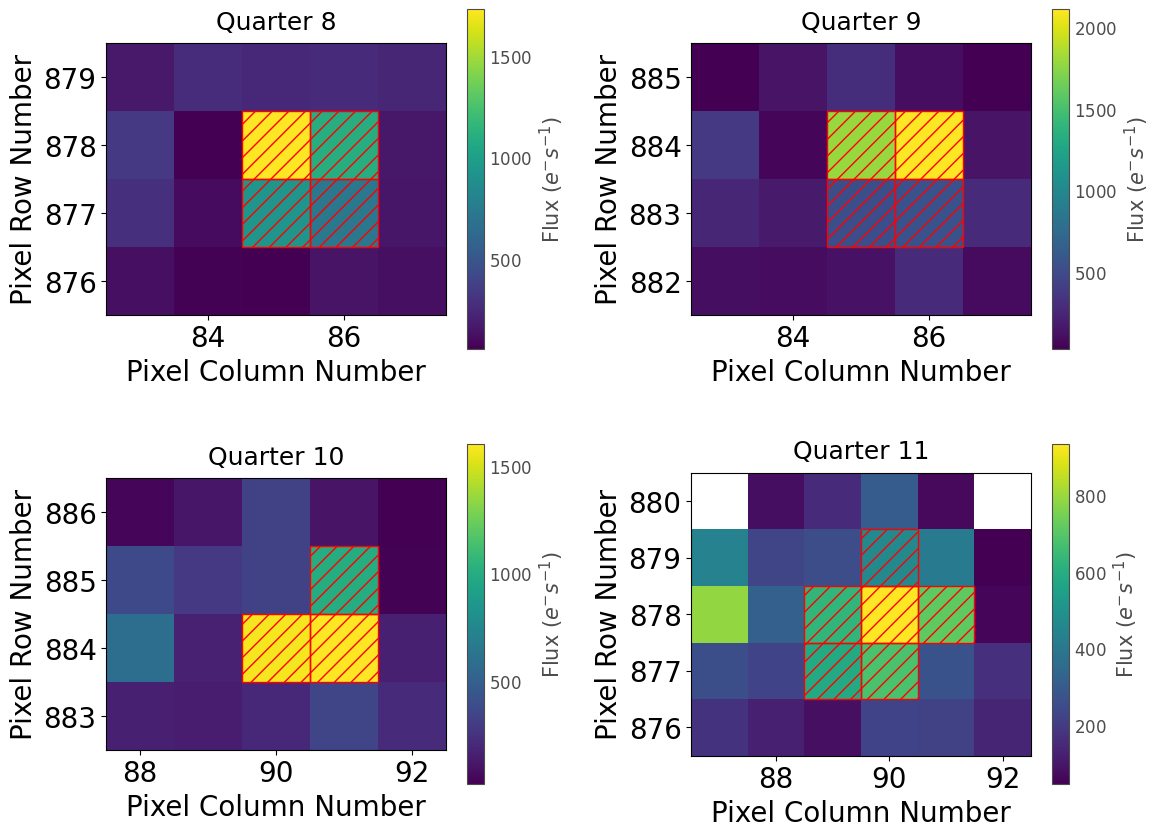

In [4]:
fig = plt.figure(figsize=(12, 9))
grid = gs.GridSpec(2, 2)

for idx, quarter in enumerate(range(8, 12)):
    x, y = np.unravel_index(idx, (2, 2))
    tpf = lk.search_targetpixelfile('KIC 2437394', author="Kepler", quarter=quarter).download()
    ax = plt.subplot(grid[x, y])
    tpf.plot(aperture_mask='pipeline', ax=ax, title=f'Quarter {quarter}')

plt.tight_layout();

KIC 2437394 is in the field of open cluster NGC 6791, meaning that crowding is a major factor in determining the optimal aperture, alongside the PRF. The changing optimal aperture leads to each quarter contributing different amounts of photon flux to the aperture photometry process, which causes discontinuities at quarter boundaries. We can see this effect by looking at the full light curve for KIC 2437394.

The following code downloads all 17 available quarters for KIC 2437394 and stitches them together, plotting them with dashed lines to indicate quarter boundaries:

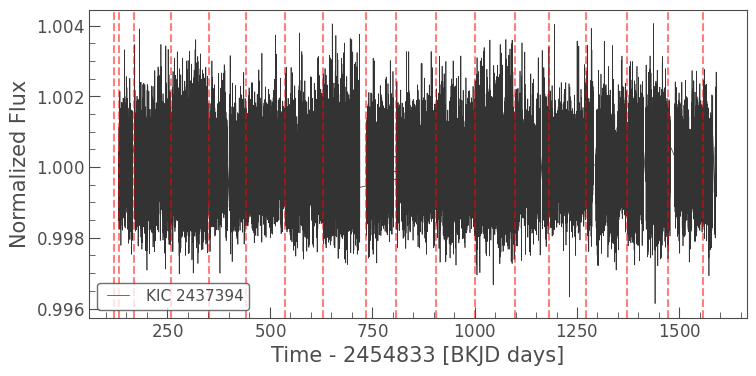

In [5]:
lc = lk.search_lightcurve('KIC 2437394', author="Kepler", cadence='long').download_all().stitch().remove_outliers()

ax = lc.plot()
quarterlines = [120, 131, 169, 259, 351, 442, 538, 629, 734, 808, 906, 1000, 1098, 1182, 1273, 1372, 1471, 1558]
for i, q in enumerate(quarterlines):
    ax.axvline(q, c='r', ls='--', alpha=0.5)

Notice how the structure of the light curve appears to rise and fall: Quarters 3, 7, and 11 (as pictured above) all have larger apertures. A larger aperture collects more photons, meaning their contribution to noise levels is also greater, and the light curve shows a larger amount of scatter in those quarters.

You can confirm this for yourself by running the code below, which prints out the standard deviation of the normalized flux in each quarter:

In [6]:
for q in range(1, 18):
  lc = lk.search_lightcurve('KIC 2437394', author="Kepler", cadence='long', quarter=q).download().normalize().remove_outliers()
  print(f'Quarter {q} standard deviation: {np.std(lc.flux.value):.1e}')

Quarter 1 standard deviation: 7.6e-04


Quarter 2 standard deviation: 8.3e-04


Quarter 3 standard deviation: 9.2e-04


Quarter 4 standard deviation: 7.5e-04


Quarter 5 standard deviation: 7.0e-04


Quarter 6 standard deviation: 8.2e-04


Quarter 7 standard deviation: 9.5e-04


Quarter 8 standard deviation: 7.6e-04


Quarter 9 standard deviation: 7.1e-04


Quarter 10 standard deviation: 8.2e-04


Quarter 11 standard deviation: 9.2e-04


Quarter 12 standard deviation: 7.8e-04


Quarter 13 standard deviation: 7.0e-04


Quarter 14 standard deviation: 8.6e-04


Quarter 15 standard deviation: 8.9e-04


Quarter 16 standard deviation: 7.5e-04


Quarter 17 standard deviation: 9.2e-04


In SAP and PDCSAP data, quarter boundary discontinuities are mostly present in stars in crowded fields. However, when performing custom aperture photometry, it's useful to be aware of this phenomenon and factor it into your choice of aperture and/or light curve corrections procedure.

## 4. Ghosts and Scattered Light

Moving away from seasonal effects now, the final phenomenon we'll look at in this tutorial is a natural consequence of the construction of the _Kepler_ telescope, as documented in the [_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf), Section 3.10. Scattered light on the detector results from bright stars which lie near the aluminium masking at the edges of modules, or between charge-coupled device (CCD) chips. As this scattering occurs in the vicinity of these bright stars, it is less likely to affect photometry beyond regular contamination, and the more diffuse it is, the less impact it has.

Ghost images are the result of reflections on the CCDs. One well-documented _Kepler_ ghost is the Schmidt Corrector Ghost, which causes stars to be reflected around the telescope's optical axis. However, these reflections are low magnitude. The type of ghost you're more likely to encounter is reflected light from very bright stars, bouncing off the field flattener lens and returning diffusely to the CCDs. The Schmidt Corrector and the field flattener are described in Sections 3.2.2 and 3.2.3 of the [_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf).

These ghosts can be a particular problem when dealing with exoplanet false positives; it is not immediately evident when one star is being contaminated by one that's far away from it.

KIC 11911580 was flagged as a _Kepler_ Object of Interest — KOI-3900 — after Quarter 12 of the mission. Let's have a look at a periodogram of its time series, and a light curve folded on the highest amplitude peak:

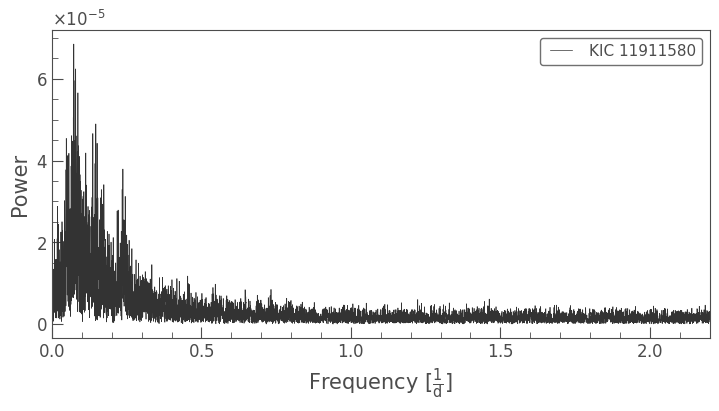

In [7]:
koi = lk.search_lightcurve('KIC 11911580', author="Kepler", cadence='long').download_all().stitch()
koi_pg = koi.remove_nans().to_periodogram()
ax = koi_pg.plot()
ax.set_xlim(0, 2.2);

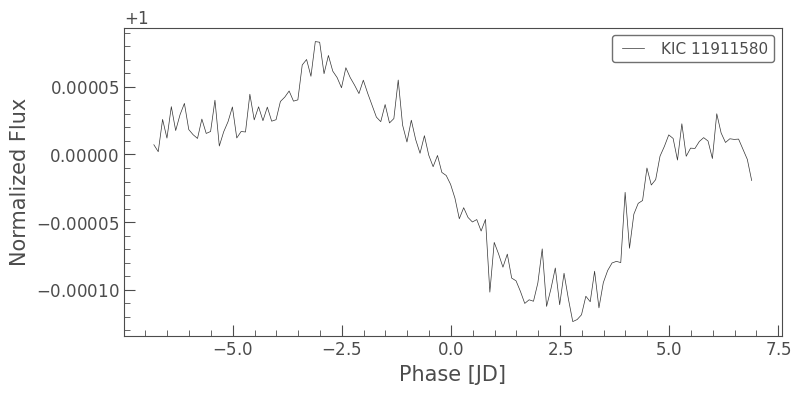

In [8]:
koi.fold(period=koi_pg.period_at_max_power).bin(time_bin_size=0.1).plot();

This does appear to be the signal of a transit, but the high noise levels in the periodogram suggest it's more likely to be the diluted signal of a nearby eclipsing binary. In the case of normal contamination, we'd use Lightkurve's [plot_pixels()](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.KeplerTargetPixelFile.plot_pixels.html) function to identify a nearby binary:

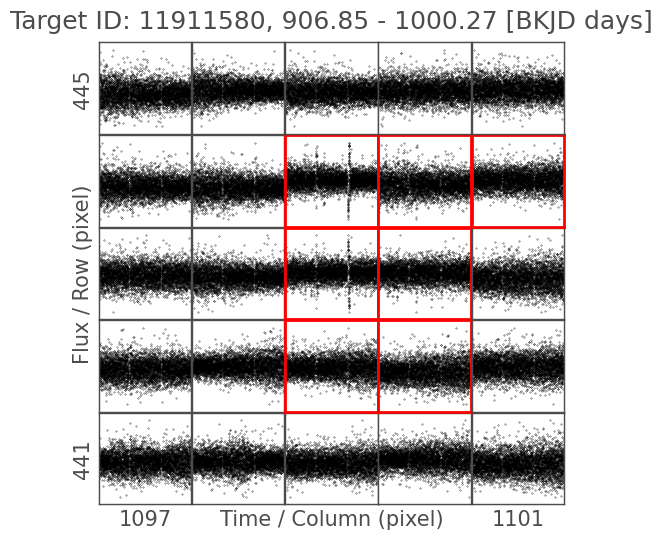

In [9]:
koi_tpf = lk.search_targetpixelfile('KIC 11911580', author="Kepler", cadence='long', quarter=10).download()
koi_tpf.plot_pixels(aperture_mask='pipeline', corrector_func=lambda x: x.flatten().remove_outliers());

There's nothing obvious here, which indicates this is a more complicated case of contamination. In fact, KOI-3900 is contaminated by KIC 3644542, an eclipsing binary 18 rows and 44 columns away from KOI-3900 on the detector. This is an example of a diffuse ghost on the detector causing a spurious variable signal to contaminate far away pixels.

KOI-3900 was determined to be a false positive due to a ghost shortly after it was flagged as a KOI, by [Coughlin et al. 2014](https://iopscience.iop.org/article/10.1088/0004-6256/147/5/119/pdf), who used ephemeris matching to compare its period to that of known eclipsing binaries. In later work, [Thompson et al. (2018)](https://iopscience.iop.org/article/10.3847/1538-4365/aab4f9/pdf) flagged false positives due to ghosts by measuring the relative strength of the signal in the optimal aperture and in background pixels.

Below, we show the periodogram and phased light curve of KIC 3644542 for comparison:

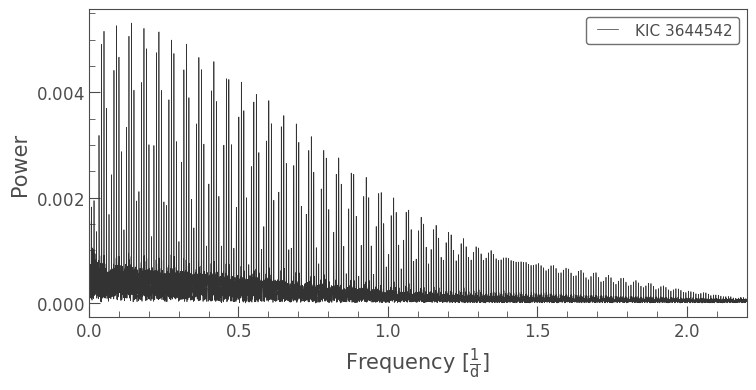

In [10]:
ghost = lk.search_lightcurve('KIC 3644542', author="Kepler", cadence='long').download_all().stitch()
ghost_pg = ghost.remove_nans().to_periodogram()
ax = ghost_pg.plot()
ax.set_xlim(0, 2.2);

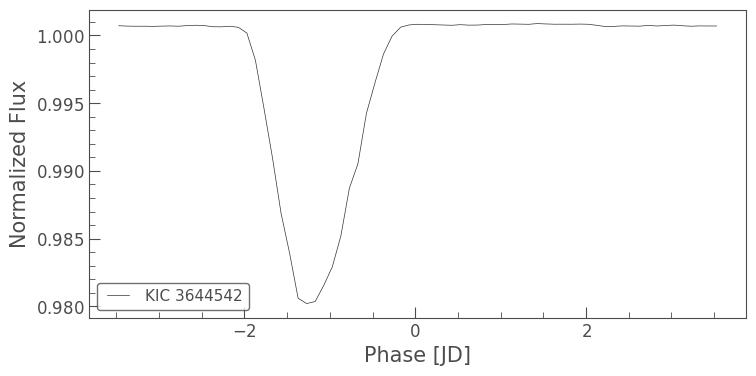

In [11]:
ghost.fold(period=ghost_pg.period_at_max_power).bin(time_bin_size=0.1).plot();

## About this Notebook

**Author:** [Isabel Colman](http://orcid.org/0000-0001-8196-516X) (`isabel.colman@sydney.edu.au`)

**Updated on:** 2020-09-29

## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [12]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>